In [16]:
#Used to find subsets of lists
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [63]:
##Helper functions

#Updates endogenous variables (V) given a certain state X,W
#i.e. sets to True/False given X or W
def V_given_set(V,X_or_W,indices):
    updated_V = V.copy()
    var_seen = 0
    for i in range(len(V)):
        if i in indices:
            updated_V[i] = X_or_W[var_seen]
            var_seen += 1
    return updated_V
    
#Creates a list of all subsets (cardinality >= 1) of a given lst
#Used https://bit.ly/2YVGYxt
def subsets_finder(indices):
    #indices corresp. to elem of some lst opposed to using indices corresp to V.
    updated_idx = [i for i in range(len(indices))]
    return [list(subset) for i in range(0, len(updated_idx)+1)
            for subset in itertools.combinations(updated_idx, i)]

#returns list of all possible splits(take indices finds all )
#Used: https://bit.ly/2KfTeFk
def partitions(indices):
    subsets = [v for a in range(len(indices)) for v in itertools.combinations(indices, a)]
    comb = []
    for i in range(len(subsets)//2 + 1):
        comb.append((list(itertools.chain(subsets[i])), [e for e in indices if e not in subsets[i]]))
    return comb
    
#Given certain indices, updates lst[i] = not lst[i] for i in indices
def negate_var(lst,indices):
    return_lst = lst.copy()
    for i in range(len(lst)):
        if(i in indices):
            return_lst[i] = not lst[i]
    return return_lst

#Extracts given elements from X using t
def extract_X(X,t):
    return_lst = []
    for i in t:
        return_lst.append(X[i])
    return return_lst


#Created a class of original H.P defn of Causality
class Causal_Model:
    #U,V,F are assumed to be lists for simplicity sake
    #Assumed that final var = outcome (e.g. last elem of V = Forest Fire)
    #U,V are boolean values corresp. to some list of var
    #F is a list of pointers to functions (e.g. def foo())
    def __init__(self, U, V, R, F):
        self.exogenous_var = U
        self.endogenous_var = V
        self.var_range = R
        self.function = F
        self.signature = (U,V,R)
        self.model = (self.signature,F)
    
    
    
    # For the following, I assume that this can be used to check causality if an outcome did not occur(?)
    
    #AC1 of defn, checks if outcome = function for given X
    #outcome_val refers to desired outcome
    def ac1_check(self,X,X_indices,outcome_function,outcome_val):
        V = V_given_set(self.endogenous_var,X,X_indices)
        outcome_given_X = outcome_function(self.exogenous_var,V)
        return outcome_given_X == outcome_val

    #AC2(a) checks the but-for clause, i.e changing X would lead to opposite outcome
    #2005 paper says W->w' but modified defn. paper says W->w, func is using the latter 
    #This function finds the correct W, and calls ac2_b
    def ac2_a_check(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val):
        V = V_given_set(self.endogenous_var,Z,Z_indices)
        V = V_given_set(V,W,W_indices)
        x_prime = [not i for i in X]
        V_given_x_prime = V_given_set(V,x_prime,X_indices)
        outcome = outcome_function(self.exogenous_var,V_given_x_prime)
        #Checks if initial W is optimal and returns
        if outcome_val != outcome:
            return True
        else:
            return False
    
    
    #Checks AC2(b) of the defn
    #Checks that outcome holds for all subsets of Z (Z') if Z' is set to original value
    def ac2_b_check(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function, outcome_val):
        V = self.endogenous_var
        V_fixed_W = V_given_set(V,W,W_indices)
        subsets_of_Z = subsets_finder(Z_indices)
        orig_Z = [V[i] for i in Z_indices]
        curr_Z = Z.copy()
        for subset in subsets_of_Z:
            for i in subset:
                curr_Z[i] = orig_Z[i]
            curr_V = V_given_set(V_fixed_W,curr_Z,Z_indices)
            outcome = outcome_function(self.exogenous_var,curr_V)
            if(outcome_val != outcome):
                return False
            else:
                curr_Z = Z.copy()
        return True
    
    #Checks AC2(b^u) of the defn
    #Checks that outcome holds for all subsets of W (W') and Z(Z') if W',Z' is set to original value
    def ac2_b_u_check(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function, outcome_val):
        V = self.endogenous_var
        subsets_of_Z = subsets_finder(Z_indices)
        subsets_of_W = subsets_finder(W_indices)
        orig_Z = [V[i] for i in Z_indices]
        curr_Z = Z.copy()
        orig_W = [V[i] for i in W_indices]
        curr_W = W.copy()
        for sub_Z in subsets_of_Z:
            for i in sub_Z:
                curr_Z[i] = orig_Z[i]
            for sub_W in subsets_of_W:
                for i in sub_W:
                    curr_W[i] = orig_W[i]
                curr_V = V_given_set(V,curr_Z,Z_indices)
                curr_V = V_given_set(curr_V,curr_W,W_indices)
                outcome = outcome_function(self.exogenous_var,curr_V)
                curr_W = W.copy()
                if(outcome_val != outcome):
                    return False
            curr_Z = Z.copy()
        return True
    
    #Returns true if ac2_a^m is satisfied
    #Also gives the coresp. W,W_indices that satisfy the defn
    #Output: [W, W_indices, T/F]
    def ac2_m_check(self,X,X_indices,outcome_function,outcome_val):
        V = self.endogenous_var
        V_indices_excluding_X = [i for i in range(len(V)) if i not in X_indices]
        potential_W_indices = subsets_finder(V_indices_excluding_X)
        subsets_X = subsets_finder(X_indices)
        for sub in subsets_X:
            curr_X = negate_var(X,sub)
            curr_V = V_given_set(V,curr_X,X_indices)
            for w_indices in potential_W_indices:
                curr_W = [V[i] for i in w_indices]
                curr_outcome = outcome_function(self.exogenous_var,curr_V)
                if(curr_outcome != outcome_val):
                    return[curr_W,w_indices,True]
        
        return [None,None,False]
    
    def ac2_check_given_Z_W(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val):
        ac2_a = self.ac2_a_check(Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val)
        ac2_b = self.ac2_b_check(Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val)
        if(ac2_a and ac2_b):
            return True
        else:
            return False
        
    def ac2_u_check_given_Z_W(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val):
        ac2_a = self.ac2_a_check(Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val)
        ac2_b = self.ac2_b_u_check(Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val)
        if(ac2_a and ac2_b):
            return True
        else:
            return False
    
    
    #Goes through all partitions of V (partitions named Z,W) and returns the first Z,W to satisfy
    #defn is an int(0,1) corresp to (original def, updated defn ('05))
    #Returns a dictionary of num_changes (from model to causal scenario) -> (corresp causal scenario's W)
    # If W_dct is empty => ac2 failed
    #If fast => return after finding first W that works
    def Z_and_W_search(self,X,X_indices,outcome_function,outcome_val,defn,fast):
        Z = X.copy()
        Z_indices = X_indices.copy()
        Useable_V_indices = [i for i in range(len(self.endogenous_var)) if i not in X_indices]
        splits = partitions(Useable_V_indices)
        W_dct = {}
        for partition in splits:
            curr_Z_indices_no_X = partition[0]
            curr_W_indices = partition[1]
            curr_Z_indices = Z_indices + curr_Z_indices_no_X
            curr_Z = [self.endogenous_var[i] for i in curr_Z_indices]
            curr_W = [self.endogenous_var[i] for i in curr_W_indices]
            ac2_check = self.ac2_check_given_Z_W(curr_Z,curr_Z_indices,X,X_indices,
                                                 curr_W,curr_W_indices,outcome_function,outcome_val)
            if(ac2_check):
                return {0:[(curr_W,curr_W_indices)]}
            else:
                curr_Z_no_X = [self.endogenous_var[i] for i in curr_Z_indices_no_X]
                subsets_of_curr_Z_no_X = subsets_finder(curr_Z_indices_no_X)
                subsets_of_curr_W = subsets_finder(curr_W_indices)
                for sub_z in subsets_of_curr_Z_no_X:
                    updated_Z = X + negate_var(curr_Z_no_X,sub_z)
                    for sub_w in subsets_of_curr_W:
                        updated_W = negate_var(curr_W,sub_w)
                        ac2_check = self.ac2_check_given_Z_W(updated_Z,curr_Z_indices,X,X_indices,updated_W,
                                                             curr_W_indices,outcome_function,outcome_val)
                        ac2_u_check = self.ac2_u_check_given_Z_W(updated_Z,curr_Z_indices,X,X_indices,updated_W,
                                                             curr_W_indices,outcome_function,outcome_val)
                        if((defn == 0 and ac2_check) or (defn == 1 and ac2_u_check)):
                            orig_W = [self.endogenous_var[i] for i in curr_W_indices]
                            num_changes = sum([1 if orig_W[i] != updated_W[i] else 0 for i in range(len(orig_W))])
                            if(fast):
                                W_dct[num_changes] = [(updated_W,curr_W_indices)]
                                return W_dct
                            elif(num_changes in W_dct):
                                num_changes_lst = W_dct[num_changes]
                                num_changes_lst.append((updated_W,curr_W_indices))
                                W_dct[num_changes] = num_changes_lst
                            else:
                                W_dct[num_changes] = [(updated_W,curr_W_indices)]

        return W_dct
                    
    
    
    
    
    #Checks that X is minimal by iterating over all subsets
    def ac3_check(self,X,X_indices,outcome_function,outcome_val):
        if(len(X) <= 1):
            return True
        
        subsets_of_X = subsets_finder(X_indices)
        for i in subsets_of_X:
            updated_X = extract_X(X,i)
            W_indices = [j for j in range(len(self.endogenous_var)) if j not in i]
            W = [self.endogenous_var[k] for k in W_indices]
            ac2_check = self.ac2_a_check(updated_X,i,updated_X,i,W,W_indices,outcome_function,outcome_val)
            if(ac2_check):
                return False
            
        return True
    #Fail checking
    def wrong_check(self,ac_1,ac_2,ac_3):
        if (not ac_1):
            print("(False b/c of AC1)")
        if(not ac_2):
            print("(False b/c of AC2)")
        if(not ac_3):
            print("(False b/c of AC3)")
    
    #Returns true if X satisfies HP defn, False o.w.
    def causality_check(self,X,X_indices,outcome_val,outcome_func,fast):
        ac_1 = self.ac1_check(X,X_indices,outcome_func,outcome_val)
        dict_to_bool = lambda x: False if len(x) == 0 else True
        ac_2 = dict_to_bool(self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0,fast))
        ac_3 = self.ac3_check(X,X_indices,outcome_func,outcome_val)
        self.wrong_check(ac_1,ac_2,ac_3)
        return ac_1 and ac_2 and ac_3
    
    #Returns true if X satisfied the modified defn. (using ac1,ac2(a),ac2(b^u), ac3 - Halpern & Pearl 2005)
    def updated_causality_check(self,X,X_indices,outcome_val,outcome_func,fast):
        ac_1 = self.ac1_check(X,X_indices,outcome_func,outcome_val)
        dict_to_bool = lambda x: False if len(x) == 0 else True
        ac_2 = dict_to_bool(self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,1,fast))
        ac_3 = self.ac3_check(X,X_indices,outcome_func,outcome_val)
        self.wrong_check(ac_1,ac_2,ac_3)
        return ac_1 and ac_2 and ac_3
    
    #Returns true if X satisfies modified defn of Halpern & Pearl 2014 (ac1, ac2_m, ac3)
    def modified_causality_check(self,X,X_indices,outcome_val,outcome_func):
        ac_1 = self.ac1_check(X,X_indices,outcome_func,outcome_val)
        ac_2 = self.ac2_m_check(X,X_indices,outcome_func,outcome_val)[2]
        ac_3 = self.ac3_check(X,X_indices,outcome_func,outcome_val)
        self.wrong_check(ac_1,ac_2,ac_3)
        return ac_1 and ac_2 and ac_3
    
    #Returns "responsibility" as per Chockler & Halpern (2004)
    # i.e. Calls Z_and_W_search and returns the min_key
    def responsibility(self,X,X_indices,outcome_val,outcome_func,fast):
        if(self.causality_check(X,X_indices,outcome_val,outcome_func,fast)):
            not_X = [not i for i in X]
            if(outcome_func(self.exogenous_var,V_given_set(self.endogenous_var,not_X,X_indices))!=outcome_val):
                return 1
            else:
                W_dct = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0,False)
                min_num_changes = min(W_dct.keys())
                return 1 / (min_num_changes + 1)
        else:
            return 0
    
    #Returns "responsibility" as per Chockler & Halpern (2004)
    # i.e. Calls Z_and_W_search and returns the MAX_key
    #If really responsibilie then max should be close intuition???
    def max_responsibility(self,X,X_indices,outcome_val,outcome_func,fast):
        if(self.causality_check(X,X_indices,outcome_val,outcome_func,fast)):
            not_X = [not i for i in X]
            if(outcome_func(self.exogenous_var,V_given_set(self.endogenous_var,not_X,X_indices))!=outcome_val):
                return 1
            else:
                W_dct = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0,fast)
                min_num_changes = max(W_dct.keys())
                return 1 / (min_num_changes + 1)
        else:
            return 0
        
    #num_outcome_var denote var in V which are not part of structural eqn. (e.g. Forest Fire)
    #Fixes X ("Causal" variable) to be X' (i.e. not x for x in X) in the model
    # Goes through each possible scenario of variable assignments in V (assuming T/F)
    # Returns num_scenarios_where_outcome_changed_from_orig / num_scenarios
    #Assumes X is only T/F valued
    def influence(self,X,X_indices,num_outcome_var,outcome_func):
        end_idx = (-1)*num_outcome_var
        V = self.endogenous_var
        V_negated_X = negate_var(V,X_indices)
        subsets_V_negated_X = subsets_finder([i for i in range(len(V_negated_X[0:end_idx]))])
        if(len(subsets_V_negated_X) == 0):
            return 0
        
        outcome_change_ct = 0
        subsets_seen = []
        for sub in subsets_V_negated_X:
            sub_no_X = [i for i in sub if i not in X_indices]
            if(sub_no_X in subsets_seen):
                continue
            
            else:
                subsets_seen.append(sub_no_X)
                V_pos_prime = negate_var(V[0:end_idx],sub_no_X)
                outcome_pos_prime = outcome_func(self.exogenous_var,V_pos_prime)
                V_neg_prime = negate_var(V_negated_X[0:end_idx],sub_no_X)
                outcome_neg_prime = outcome_func(self.exogenous_var,V_neg_prime)
                if(outcome_pos_prime != outcome_neg_prime):
                    outcome_change_ct += 1
        return outcome_change_ct / len(subsets_seen)
    
    #Adj responsibility = influence*responsibility
    def adj_responsibility(self,X,X_indices,num_outcome_var,outcome_val,outcome_func,fast):
        inf = self.influence(X,X_indices,num_outcome_var,outcome_func)
        res = self.responsibility(X,X_indices,outcome_val,outcome_func,fast)
        return inf*res
    
    #Adj responsibility_2 = sum of influence of var in W that change
    #If multiple W, computes the above ^ for each W and sums together
    #Returns 0 if X not Causal
    
    #Changing this to responsibility in every W generated world, using regularization (divide by num_W_generated)
    def adj_responsibility_2(self,X,X_indices,num_outcome_var,outcome_val,outcome_func,fast):
        if(self.causality_check(X,X_indices,outcome_val,outcome_func,fast)):
            not_X = [not i for i in X]
            if(outcome_func(self.exogenous_var,V_given_set(self.endogenous_var,not_X,X_indices))!=outcome_val):
                return 1
            else:
                W_dct = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0,fast)
                W_dct_keys = W_dct.keys()
                min_key = min(W_dct_keys)
                W_indices = W_dct[min_key][0][1]
                orig_W = [self.endogenous_var[i] for i in W_indices]
                inf = self.influence(orig_W,W_indices,num_outcome_var,outcome_func)
                if(len(W_dct[min_key])>1):
                    print("!!!")
                return 1 / (1+len(W_dct[min_key])*min_key*inf)
        else:
            return 0
    
    #This function returns adj_2 and zultan at once (to save time)
    def adj_responsibility_2m(self,X,X_indices,num_outcome_var,outcome_val,outcome_func,fast):
        if(not self.causality_check(X,X_indices,outcome_val,outcome_func,True)):
            return (0,0)
        
        else:
            not_X = [not i for i in X]
            if(outcome_func(self.exogenous_var,V_given_set(self.endogenous_var,not_X,X_indices))!=outcome_val):
                return (1,1)
            else:
                W_dct = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0,fast)
                W_dct_keys = W_dct.keys()
                min_key = min(W_dct_keys)
                W_indices = W_dct[min_key][0][1]
                orig_W = [self.endogenous_var[i] for i in W_indices]
                inf = self.influence(orig_W,W_indices,num_outcome_var,outcome_func)
                if(len(W_dct[min_key])>1):
                    print("!!!")
                adj_2_outcome = 1 / (1+len(W_dct[min_key])*min_key*inf)
        #zultan:
                paths = [1*(1/(k+1)) for k in W_dct_keys]
                total_num_changes = 1/sum(paths)
                return (adj_2_outcome,1/(total_num_changes + 1))
        
        
    #Using Multiple Counterfactual Pivotality model from Zultan, Gerstenberg, Lagnado 2012
    # If there are multiple ways that a variable X can become causal (via but-for) then instead of
    # using the 1 / (1 + min(changes_to_W)) we will change the denom to (1+N)
    # N = 1 / (sum of 1/c_i) where c_i is the number of changes to W in "path" i
    #this iterates over all possible paths where X is pivotal
    #If X is pivotal : returns 1
    #Returns 0 if X is not causal
    def zultan_responsibility(self,X,X_indices,outcome_val,outcome_func):
        if(self.causality_check(X,X_indices,outcome_val,outcome_func,True)):
            not_X = [not i for i in X]
            if(outcome_func(self.exogenous_var,V_given_set(self.endogenous_var,not_X,X_indices)) != outcome_val):
                return 1
            W_dict = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0,False)
            W_dct_keys = W_dict.keys()
            paths = [len(W_dct[k])*(1/k) for k in W_dct_keys]
            total_num_changes = 1/sum(paths)
            return 1/(total_num_changes + 1)
        else:
            return 0
    #Influence function but only samples n states (assuming n >= 1)
    #Saves time as inf function is exponential ; mc = Monte Carlo method to sample from uniform [0,1]
    def mc_inf_sample(self,X,X_indices,num_outcome_var,outcome_func,n):
        if(n <= 0):
            raise ValueError
        V = self.endogenous_var
        v_idx_to_change = [i for i in range(len(V[0:(-1)*num_outcome_var])) if i not in X_indices]
        outcome_change_ct = 0
        seen = []
        for i in range(n):
            random_vec = np.random.randint(2,size = len(v_idx_to_change))
            changeable_var_vec = [True if random_vec[i] == 1 else False for i in range(len(random_vec))]
            curr_V_pos = V_given_set(V,changeable_var_vec,v_idx_to_change)
            curr_V_neg = negate_var(curr_V_pos,X_indices)
            outcome_pos = outcome_func(self.exogenous_var,curr_V_pos)
            outcome_neg = outcome_func(self.exogenous_var,curr_V_neg)
            if(outcome_pos != outcome_neg):
                outcome_change_ct += 1

        return outcome_change_ct / n

## Testing
### Using examples from 2005 HP paper

### Example 2.1: Forest Fire (F) caused by either Lightning (L) or Match Lit (ML) 

In [3]:
#Initializes U to True for random exogen. var (val/var not important)
# V = True for all
#R is trivially set to 0 or 1
# Index[0] = L ; Index[1] = ML ; Index[2] = F
U = [True,True,True]
V = [True,True,True]
R = [(False,True),(False,True),(False,True)]
def forest_fire(U,V):
    return V[0] or V[1]
F_f = forest_fire
F = [None, None, F_f]
FF_model = Causal_Model(U,V,R,F)

In [4]:
X = [True]
X_index = [0]
print("Testing Casuality of Lightning (Correct Val = True):")
print(FF_model.causality_check(X,X_index,True,F_f,False))
print("\nTesting Updated Casuality of Lightning (Correct Val = True):")
print(FF_model.updated_causality_check(X,X_index,True,F_f,False))
print("\nTesting Modified Casuality of Lightning (Correct Val = False (b/c partial causes are not treated as causes)):")
print(FF_model.modified_causality_check(X,X_index,True,F_f))

Testing Casuality of Lightning (Correct Val = True):
True

Testing Updated Casuality of Lightning (Correct Val = True):
True

Testing Modified Casuality of Lightning (Correct Val = False (b/c partial causes are not treated as causes)):
(False b/c of AC2)
False


In [5]:
print("Testing Responsibility of Lightning(Expect: 1)")
print(FF_model.responsibility(X,X_index,True,F_f,False))

Testing Responsibility of Lightning(Expect: 1)
1.0


In [6]:
print("Adj_1 Responsibility of Lightning")
print(FF_model.adj_responsibility(X,X_index,1,True,F_f,False))
print("\nAdj_2 Responsibility of Lightning")
print(FF_model.adj_responsibility_2(X,X_index,1,True,F_f,False))
print("\nZultan Responsibility of Lightning")
print(FF_model.zultan_responsibility(X,X_index,True,F_f))

Adj_1 Responsibility of Lightning
0.5

Adj_2 Responsibility of Lightning
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
0

Zultan Responsibility of Lightning
0.25


In [7]:
X_ml = [True]
X_ml_index = [1]
print("Testing for Causality of ML (Correct Val = True):")
print(FF_model.causality_check(X_ml,X_ml_index,True,F_f,False))
print("\nTesting for Updated Causality of ML (Correct Val = True):")
print(FF_model.updated_causality_check(X_ml,X_ml_index,True,F_f,False))
print("\nTesting for Modified Causality of ML (Correct Val = False (partial cause)):")
print(FF_model.modified_causality_check(X_ml,X_ml_index,True,F_f))

Testing for Causality of ML (Correct Val = True):
True

Testing for Updated Causality of ML (Correct Val = True):
True

Testing for Modified Causality of ML (Correct Val = False (partial cause)):
(False b/c of AC2)
False


In [8]:
print("Testing Responsibility of ML(Expect: 1)")
print(FF_model.responsibility(X,X_index,True,F_f,False))

Testing Responsibility of ML(Expect: 1)
1.0


In [9]:
print("Adj Responsibility of ML")
print(FF_model.adj_responsibility(X,X_index,1,True,F_f,False))
print("\nAdj_2 Responsibility of ML")
print(FF_model.adj_responsibility_2(X,X_index,1,True,F_f,False))
print("\nZultan Responsibility of ML")
print(FF_model.zultan_responsibility(X,X_index,True,F_f))

Adj Responsibility of ML
0.5

Adj_2 Responsibility of ML
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
0

Zultan Responsibility of ML
0.25


In [10]:
X_both = [True,True]
X_both_index = [0,1]
print("Testing for Causality of BOTH (Correct Val = False (not minimal)):")
print(FF_model.causality_check(X_both,X_both_index,True,F_f,False))
print("\nTesting for Updated Causality of Both (Correct Val = False):")
print(FF_model.updated_causality_check(X_both,X_both_index,True,F_f,False))
print("\nTesting for Modified Causality of Both (Correct Val = False):")
print(FF_model.modified_causality_check(X_both,X_both_index,True,F_f))

Testing for Causality of BOTH (Correct Val = False (not minimal)):
(False b/c of AC3)
False

Testing for Updated Causality of Both (Correct Val = False):
(False b/c of AC3)
False

Testing for Modified Causality of Both (Correct Val = False):
(False b/c of AC3)
False


## Example 3.2 - Case 1 (Disjunctive): 
### Two Arsonists drop lit matches, either match suffices to burn the forest down

In [11]:
#U = [Some Condition, Intention of Arsonist 1, Intention of Arsonist 2, Intention of both]
#V  = [Match_Lit_Arsonist_1, Match_Lit_Aronist_2, ForestFire]
U = [True,True,True,True]
V = [True,True,True]
R = [(False,True),(False,True),(False,True)]
def disjunctive_forest_fire(U,V):
    return V[0] or V[1]
F_df = [None,None,disjunctive_forest_fire]
Arson_model = Causal_Model(U,V,R,F_df)

In [12]:
X = [True]
X_index = [0]
print("Testing Casuality of Arsonist 1(Correct Val = True):")
print(Arson_model.causality_check(X,X_index,True,disjunctive_forest_fire,False))
print("\nTesting Updated Casuality of Arsonist 1(Correct Val = True):")
print(Arson_model.updated_causality_check(X,X_index,True,disjunctive_forest_fire,False))
print("\nTesting Modified Casuality of Arsonist 1(Correct Val = False (partial)):")
print(Arson_model.modified_causality_check(X,X_index,True,disjunctive_forest_fire))

print("\n Testing Responsibility of Arsonist 1:")
print(Arson_model.responsibility(X,X_index,True,disjunctive_forest_fire,False))

print("\n Adj. Responsibility of Arsonist 1:")
print(Arson_model.adj_responsibility(X,X_index,1,True,disjunctive_forest_fire,False))
print("\n Adj_2 Responsibility of Arsonist 1:")
print(Arson_model.adj_responsibility_2(X,X_index,1,True,disjunctive_forest_fire,False))
print("\nZultan Responsibility of Arsonist 1")
print(FF_model.zultan_responsibility(X,X_index,True,disjunctive_forest_fire))

Testing Casuality of Arsonist 1(Correct Val = True):
True

Testing Updated Casuality of Arsonist 1(Correct Val = True):
True

Testing Modified Casuality of Arsonist 1(Correct Val = False (partial)):
(False b/c of AC2)
False

 Testing Responsibility of Arsonist 1:
1.0

 Adj. Responsibility of Arsonist 1:
0.5

 Adj_2 Responsibility of Arsonist 1:
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
0

Zultan Responsibility of Arsonist 1
0.25


In [13]:
X = [True]
X_index = [1]
print("Testing Casuality of Arsonist 2(Correct Val = True):")
print(Arson_model.causality_check(X,X_index,True,disjunctive_forest_fire,False))
print("\nTesting Updated Casuality of Arsonist 1(Correct Val = True):")
print(Arson_model.updated_causality_check(X,X_index,True,disjunctive_forest_fire,False))
print("\nTesting Modified Casuality of Arsonist 1(Correct Val = False):")
print(Arson_model.modified_causality_check(X,X_index,True,disjunctive_forest_fire))

print("\n Testing Responsibility of Arsonist 2:")
print(Arson_model.responsibility(X,X_index,True,disjunctive_forest_fire,False))

print("\n Adj. Responsibility of Arsonist 2:")
print(Arson_model.adj_responsibility(X,X_index,1,True,disjunctive_forest_fire,False))
print("\n Adj_2 Responsibility of Arsonist 2:")
print(Arson_model.adj_responsibility_2(X,X_index,1,True,disjunctive_forest_fire,False))
print("\nZultan Responsibility of Arsonist 2")
print(FF_model.zultan_responsibility(X,X_index,True,disjunctive_forest_fire))

Testing Casuality of Arsonist 2(Correct Val = True):
True

Testing Updated Casuality of Arsonist 1(Correct Val = True):
True

Testing Modified Casuality of Arsonist 1(Correct Val = False):
(False b/c of AC2)
False

 Testing Responsibility of Arsonist 2:
0.5

 Adj. Responsibility of Arsonist 2:
0.25

 Adj_2 Responsibility of Arsonist 2:
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
0

Zultan Responsibility of Arsonist 2
0.25


In [14]:
X = [True,True]
X_index = [0,1]
print("Testing Casuality of BOTH(Correct Val = False (b/c not minimal)):")
print(Arson_model.causality_check(X,X_index,True,disjunctive_forest_fire,False))
print("\n Testing Updated Casuality of BOTH(Correct Val = False (b/c not minimal)):")
print(Arson_model.updated_causality_check(X,X_index,True,disjunctive_forest_fire,False))
print("\n Testing modified Casuality of BOTH(Correct Val = False (b/c not minimal)):")
print(Arson_model.modified_causality_check(X,X_index,True,disjunctive_forest_fire))
print("\nZultan Responsibility of BOTH")
print(FF_model.zultan_responsibility(X,X_index,True,disjunctive_forest_fire))

Testing Casuality of BOTH(Correct Val = False (b/c not minimal)):
(False b/c of AC3)
False

 Testing Updated Casuality of BOTH(Correct Val = False (b/c not minimal)):
(False b/c of AC3)
False

 Testing modified Casuality of BOTH(Correct Val = False (b/c not minimal)):
(False b/c of AC3)
False

Zultan Responsibility of BOTH
(False b/c of AC3)
0


## Example 3.2 - Case 2 (Conjuctive): 
### Two Arsonists drop lit matches, need BOTH matches to burn forest

In [15]:
#U = [Some Condition, Intention of Arsonist 1, Intention of Arsonist 2, Intention of both]
#V  = [Match_Lit_Arsonist_1, Match_Lit_Aronist_2, ForestFire]
U = [True,True,True,True]
V = [True,True,True]
R = [(False,True),(False,True),(False,True)]
def conjunctive_forest_fire(U,V):
    return V[0] and V[1]
F_df = [None,None,conjunctive_forest_fire]
Arson2_model = Causal_Model(U,V,R,F_df)

In [16]:
X = [True]
X_index = [0]
print("Testing Casuality of ONLY Arsonist 1(Correct Val = True):")
print(Arson2_model.causality_check(X,X_index,True,conjunctive_forest_fire,False))
print("\nTesting Updated Casuality of ONLY Arsonist 1(Correct Val = True):")
print(Arson2_model.updated_causality_check(X,X_index,True,conjunctive_forest_fire,False))
print("\nTesting modified Casuality of ONLY Arsonist 1(Correct Val = True):")
print(Arson2_model.modified_causality_check(X,X_index,True,conjunctive_forest_fire))

print("\n Responsibility of ONLY Arsonist 1")
print(Arson2_model.responsibility(X,X_index,True,conjunctive_forest_fire,False))
print("\n Adj. Responsibility of \"")
print(Arson2_model.adj_responsibility(X,X_index,1,True,conjunctive_forest_fire,False))
print("\n Adj_2. Responsibility of \"")
print(Arson2_model.adj_responsibility_2(X,X_index,1,True,conjunctive_forest_fire,False))
print("\nZultan Responsibility of \"")
print(FF_model.zultan_responsibility(X,X_index,True,conjunctive_forest_fire))

Testing Casuality of ONLY Arsonist 1(Correct Val = True):
True

Testing Updated Casuality of ONLY Arsonist 1(Correct Val = True):
True

Testing modified Casuality of ONLY Arsonist 1(Correct Val = True):
True

 Responsibility of ONLY Arsonist 1
1

 Adj. Responsibility of "
0.5

 Adj_2. Responsibility of "
0

Zultan Responsibility of "
1


In [17]:
X = [True]
X_index = [1]
print("Testing Casuality of ONLY Arsonist 2(Correct Val = True):")
print(Arson2_model.causality_check(X,X_index,True,conjunctive_forest_fire,False))
print("\nTesting Updated Casuality of ONLY Arsonist 2(Correct Val = True):")
print(Arson2_model.updated_causality_check(X,X_index,True,conjunctive_forest_fire,False))
print("\nTesting modified Casuality of ONLY Arsonist 2(Correct Val = True):")
print(Arson2_model.modified_causality_check(X,X_index,True,conjunctive_forest_fire))

print("\n Responsibility of ONLY Arsonist 2")
print(Arson2_model.responsibility(X,X_index,True,conjunctive_forest_fire,False))
print("\n Adj. Responsibility of \"")
print(Arson2_model.adj_responsibility(X,X_index,1,True,conjunctive_forest_fire,False))
print("\n Adj_2. Responsibility of \"")
print(Arson2_model.adj_responsibility_2(X,X_index,1,True,conjunctive_forest_fire,False))
print("\nZultan Responsibility of \"")
print(FF_model.zultan_responsibility(X,X_index,True,conjunctive_forest_fire))

Testing Casuality of ONLY Arsonist 2(Correct Val = True):
True

Testing Updated Casuality of ONLY Arsonist 2(Correct Val = True):
True

Testing modified Casuality of ONLY Arsonist 2(Correct Val = True):
True

 Responsibility of ONLY Arsonist 2
1

 Adj. Responsibility of "
0.5

 Adj_2. Responsibility of "
0

Zultan Responsibility of "
1


In [18]:
X = [True,True]
X_index = [0,1]
print("Testing Casuality of BOTH Arsonists (Correct Val = False):")
print(Arson2_model.causality_check(X,X_index,True,conjunctive_forest_fire,False))
print("\nTesting Updated Casuality of BOTH(Correct Val = False):")
print(Arson2_model.updated_causality_check(X,X_index,True,conjunctive_forest_fire,False))
print("\nTesting modified Casuality of BOTH(Correct Val = False):")
print(Arson2_model.modified_causality_check(X,X_index,True,conjunctive_forest_fire))
print("\nZultan Responsibility of BOTH")
print(FF_model.zultan_responsibility(X,X_index,True,conjunctive_forest_fire))

Testing Casuality of BOTH Arsonists (Correct Val = False):
(False b/c of AC3)
False

Testing Updated Casuality of BOTH(Correct Val = False):
(False b/c of AC3)
False

Testing modified Casuality of BOTH(Correct Val = False):
(False b/c of AC3)
False

Zultan Responsibility of BOTH
(False b/c of AC3)
0


## Example 4.1: 
### Rain in April,May (+Electric Showers in May/June) and then lightning in June -> Forest Fire
### Question: Did April's showers cause the fire in June opposed to May?

In [19]:
#U is trivial let it be (for e.g.) U[0] = sufficient FF conditions in May U[1] = [...] in June
#V[0] = April Showers; V[1] = No Electric Storm (E.s) (May or June) V[2] = E.S only in May V[3] = E.S only in June 
#V[4] = E.S. Both; V[5] = FF in May V[6] = No FF in May V[7] = FF in June
# R is trivial
U = [True,True]
V = [True,False,False,False,True,False,False,True]
R = [(False, True),(False, True),(False,True),(False,True),(False,True),(False,True),(False,True)]
def April_showers_bring_June_Fires(U,V):
    return V[0] and (V[3] or V[4])
F_storms = [None,None,None,None,None,None,None,April_showers_bring_June_Fires]
Storm_FF = Causal_Model(U,V,R,F_storms)

In [20]:
X = [True]
X_index = [0]
fast = False
print("Testing Causality of April Showers on June Fire: (Correct Val = True)")
print(Storm_FF.causality_check(X,X_index,True,April_showers_bring_June_Fires,fast))
print("\n Testing Updated Causality of April Showers on June Fire: (Correct Val = True)")
print(Storm_FF.updated_causality_check(X,X_index,True,April_showers_bring_June_Fires,fast))
print("\n Testing modified Causality of April Showers on June Fire: (Correct Val = True)")
print(Storm_FF.modified_causality_check(X,X_index,True,April_showers_bring_June_Fires))

print("\n Responsibility of \"")
print(Storm_FF.responsibility(X,X_index,True,April_showers_bring_June_Fires,fast))
print("\n Adj. Responsibility of \"")
print(Storm_FF.adj_responsibility(X,X_index,3,True,April_showers_bring_June_Fires,fast))
print("\n Adj_2. Responsibility of \"")
print(Storm_FF.adj_responsibility_2(X,X_index,3,True,April_showers_bring_June_Fires,fast))
print("\nZultan Responsibility of \"")
print(Storm_FF.zultan_responsibility(X,X_index,True,April_showers_bring_June_Fires))

Testing Causality of April Showers on June Fire: (Correct Val = True)
True

 Testing Updated Causality of April Showers on June Fire: (Correct Val = True)
True

 Testing modified Causality of April Showers on June Fire: (Correct Val = True)
True

 Responsibility of "
1

 Adj. Responsibility of "
0.75

 Adj_2. Responsibility of "
0

Zultan Responsibility of "
1


In [21]:
X = [True,True]
X_index = [0,4]
print("Testing Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))")
print(Storm_FF.causality_check(X,X_index,True,April_showers_bring_June_Fires,fast))
print("\n Testing Updated Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))")
print(Storm_FF.updated_causality_check(X,X_index,True,April_showers_bring_June_Fires,fast))
print("\n Testing modified Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))")
print(Storm_FF.modified_causality_check(X,X_index,True,April_showers_bring_June_Fires))

Testing Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))
(False b/c of AC3)
False

 Testing Updated Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))
(False b/c of AC3)
False

 Testing modified Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))
(False b/c of AC3)
False



## Example 4.2
### Suzy and Billy throw rocks at a bottle. Suzy's rock hits the bottle first, causing it to shatter. However, had she not thrown, Billy's rock would have shattered the bottle.
### Is Suzy a cause of bottle shattering?

In [22]:
#Initializes U to some random exogenous var (e.g. Suzy,Billy state of mind)
#V[0] = Suzy Throws ; V[1] = Suzy's Rock Hits Bottle; V[2] = Billy Throws; 
# V[3] = Billy Rock Hits Bottle; V[4] = Bottle Shatters
U = [True, True]
V = [True,True,True,False,True]
R = [(False,True),(False,True),(False,True)]
#bottle shatters in this scenario (where Suzy is first)
def bottle_shatters(U,V):
    return (V[0] and V[1])
F_SB = [None,None,bottle_shatters]
SB_model = Causal_Model(U,V,R,F_SB)

In [23]:
X = [True]
X_index = [0]
print("Testing Casuality of Suzy Throw/Hit(Correct Val = True):")
print(SB_model.causality_check(X,X_index,True,bottle_shatters,fast))
print("\n Testing Updated Casuality of Suzy Throw/Hit(Correct Val = True):")
print(SB_model.updated_causality_check(X,X_index,True,bottle_shatters,fast))
print("\n Testing modified Casuality of Suzy Throw/Hit(Correct Val = True):")
print(SB_model.modified_causality_check(X,X_index,True,bottle_shatters))

print("\nResponsibility of \"")
print(SB_model.responsibility(X,X_index,True,bottle_shatters,fast))
print("\nAdj. Responsibility of \"")
print(SB_model.adj_responsibility(X,X_index,1,True,bottle_shatters,fast))
print("\nAdj_2. Responsibility of \"")
print(SB_model.adj_responsibility_2(X,X_index,1,True,bottle_shatters,fast))
print("\nZultan Responsibility of \"")
print(SB_model.zultan_responsibility(X,X_index,True,bottle_shatters))

Testing Casuality of Suzy Throw/Hit(Correct Val = True):
True

 Testing Updated Casuality of Suzy Throw/Hit(Correct Val = True):
True

 Testing modified Casuality of Suzy Throw/Hit(Correct Val = True):
True

Responsibility of "
1

Adj. Responsibility of "
0.5

Adj_2. Responsibility of "
0

Zultan Responsibility of "
1


In [24]:
X = [True]
X_index = [2]
print("Testing Casuality of Billy Throw(Correct Val = False):")
print(SB_model.causality_check(X,X_index,True,bottle_shatters,fast))
print("\n Testing Updated Casuality of Billy Throw(Correct Val = False):")
print(SB_model.updated_causality_check(X,X_index,True,bottle_shatters,fast))
print("\n Testing modified Casuality of Billy Throw(Correct Val = False):")
print(SB_model.modified_causality_check(X,X_index,True,bottle_shatters))

Testing Casuality of Billy Throw(Correct Val = False):
(False b/c of AC2)
False

 Testing Updated Casuality of Billy Throw(Correct Val = False):
(False b/c of AC2)
False

 Testing modified Casuality of Billy Throw(Correct Val = False):
(False b/c of AC2)
False


## Example 4.3
### Billy is hospitalized on Monday, Dr. forgets to give medication on Monday. Say Dr. on Monday and Dr. on Tuesday are reliable and the following twist: one dose is harmless, two doses are lethal.


In [25]:
# U is trivial, say it is U[0] = Medicine available Mon.  U[1] = [...] on Tuesday 
# V[0] = Given medicine on Monday (MT)
#V[1] = Given medicine on Tuesday (TT)
# V[2] = Billy alive on Tuesday Morning 
# V[3] = Billy alive and well on Tuesday Morning
# V[4] = Billy sick on Tuesday Mornining (and alive) and recovers Tuesday afternoon
# V[5] = Billy sick Tuesday morning and afternoon (so missed treatment?)
# V[6] = Billy recovered Tuesday morning and is dead Tuesday afternoon 
U = [True,True]
V = [True,False,True,False,True,False,False]
R = [(False, True),(False, True),(False,True),(False,True),(False,True),(False,True)]
def billy_alive(U,V):
    return V[2] or V[3] or V[4] or V[5]
def billy_dead(U,V):
    return V[0] and V[1]
F_billy = [None,None,billy_alive,billy_alive,billy_alive,billy_dead]
Billy_model = Causal_Model(U,V,R,F_billy)

In [26]:
X = [True]
X_index = [0]
print("Testing if MT = 1 is a cause of Billy alive (Expected: False)")
print(Billy_model.causality_check(X,X_index,True,billy_alive,fast))
print("\n Testing if MT = 1 is a cause (using updated defn) of Billy alive (Expected: False)")
print(Billy_model.updated_causality_check(X,X_index,True,billy_alive,fast))
print("\n Testing if MT = 1 is a cause (using modified defn) of Billy alive (Expected: False)")
print(Billy_model.modified_causality_check(X,X_index,True,billy_alive))

Testing if MT = 1 is a cause of Billy alive (Expected: False)
(False b/c of AC2)
False

 Testing if MT = 1 is a cause (using updated defn) of Billy alive (Expected: False)
(False b/c of AC2)
False

 Testing if MT = 1 is a cause (using modified defn) of Billy alive (Expected: False)
(False b/c of AC2)
False


In [27]:
X = [True]
X_index = [1]
print("Testing if TT=1 is a cause of Billy Dead (Expected: True)")
print(Billy_model.causality_check(X,X_index,True,billy_dead,fast))
print("\nTesting if TT=1 is a cause (using updated defn.) of Billy Dead (Expected: True)")
print(Billy_model.updated_causality_check(X,X_index,True,billy_dead,fast))
print("\nTesting if TT=1 is a cause (using modified defn.) of Billy Dead (Expected: True)")
print(Billy_model.modified_causality_check(X,X_index,True,billy_dead))

Testing if TT=1 is a cause of Billy Dead (Expected: True)
(False b/c of AC2)
False

Testing if TT=1 is a cause (using updated defn.) of Billy Dead (Expected: True)
(False b/c of AC2)
False

Testing if TT=1 is a cause (using modified defn.) of Billy Dead (Expected: True)
True


In [28]:
def tuesday_treatment(U,V):
    return not V[0]
X = [True]
X_index = [0]
print("Testing if MT=1 is a cause of TT = 0(Expected: True)")
print(Billy_model.causality_check(X,X_index,False,tuesday_treatment,False))
print("\nTesting if MT=1 is a cause (using updated defn.) of TT = 0(Expected: True)")
print(Billy_model.updated_causality_check(X,X_index,False,tuesday_treatment,False))
print("\nTesting if MT=1 is a cause (using modified defn.) of TT = 0(Expected: True)")
print(Billy_model.modified_causality_check(X,X_index,False,tuesday_treatment))

Testing if MT=1 is a cause of TT = 0(Expected: True)
True

Testing if MT=1 is a cause (using updated defn.) of TT = 0(Expected: True)
True

Testing if MT=1 is a cause (using modified defn.) of TT = 0(Expected: True)
True


## Example (Responsibility Check): Case 1
### Election between Candidate A and Candidate B w/ result 7-0 (tweaked from 11-0 for faster testing)
### Is each voter a cause of Candidate A's victory? What is the responsibility of each voter

In [29]:
U = [True for i in range(7)]
V = U + [True,False]
R = [(False,True) for i in range(9)]
def A_victory(U,V):
    return sum([1 for vote in V[0:7] if vote == True]) > 3
F = [None for i in range(7)] + [A_victory, not A_victory]
Election_Case_1 = Causal_Model(U,V,R,F)

In [107]:
X = [True]
X_index = [0]
for i in range(7):
    X_index = [i]
    print("Testing Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_1.causality_check(X,X_index,True,A_victory,True))
    print("\nTesting (Updated Defn.)Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_1.updated_causality_check(X,X_index,True,A_victory,True))
    print("\nTesting (modified Defn.)Causality of Voter " + str(i+1) + " (Expected: False (partial))")
    print(Election_Case_1.modified_causality_check(X,X_index,True,A_victory))
    print("--------")

Testing Causality of Voter 1 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 1 (Expected: True)
True

Testing (modified Defn.)Causality of Voter 1 (Expected: False (partial))
(False b/c of AC2)
False
--------
Testing Causality of Voter 2 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 2 (Expected: True)
True

Testing (modified Defn.)Causality of Voter 2 (Expected: False (partial))
(False b/c of AC2)
False
--------
Testing Causality of Voter 3 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 3 (Expected: True)
True

Testing (modified Defn.)Causality of Voter 3 (Expected: False (partial))
(False b/c of AC2)
False
--------
Testing Causality of Voter 4 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 4 (Expected: True)
True

Testing (modified Defn.)Causality of Voter 4 (Expected: False (partial))
(False b/c of AC2)
False
--------
Testing Causality of Voter 5 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 5 

In [108]:
X = [True]
X_index = [0]
for i in range(3):
    X_index = [i]
    print("\nTesting Responsibility of Voter " + str(i+1) + " (Expected: 1/4)")
    print(Election_Case_1.responsibility(X,X_index,True,A_victory,True))
    print("\nTesting Influence of Voter " + str(i+1))
    print(Election_Case_1.influence(X,X_index,2,A_victory))
    print("\nAdj Responsibility of \"")
    print(Election_Case_1.adj_responsibility(X,X_index,2,True,A_victory,True))
    adj_zult = Election_Case_1.adj_responsibility_2m(X,X_index,2,True,A_victory,True)
    print("\nAdj_2 Responsibility of \"")
    print(adj_zult[0])
    print("\nZultan Responsibility of \"")
    print(adj_zult[1])
    print("------------------------------------------------")


Testing Responsibility of Voter 1 (Expected: 1/4)
0.25

Testing Influence of Voter 1
0.3125

Adj Responsibility of "
0.078125

Adj_2 Responsibility of "
7544.999999999636

Zultan Responsibility of "
0.0625
------------------------------------------------

Testing Responsibility of Voter 2 (Expected: 1/4)
0.25

Testing Influence of Voter 2
0.3125

Adj Responsibility of "
0.078125


KeyboardInterrupt: 

## Example (Responsibility Check): Case 2
### Election between Candidate A and Candidate B w/ result 4-3 (tweaked from 6-5 for faster testing)
### Is each voter a cause of Candidate A's victory? What is the responsibility of each voter

In [30]:
U = [True for i in range(4)] + [False for i in range(3)]
V = U + [True,False]
R = [(False,True) for i in range(9)]
def A_victory(U,V):
    return sum([1 for vote in V[0:7] if vote == True]) > 3
F = [None for i in range(7)] + [A_victory, not A_victory]
Election_Case_2 = Causal_Model(U,V,R,F)

In [283]:
X = [True]
X_index = [0]
for i in range(7):
    X_index = [i]
    print("Testing Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_2.causality_check(X,X_index,True,A_victory,False))
    print("\nTesting (Updated Defn.) Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_2.updated_causality_check(X,X_index,True,A_victory,False))
    print("\nTesting (modified Defn.) Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_2.modified_causality_check(X,X_index,True,A_victory))
    print("-----------------------")

Testing Causality of Voter 1 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 1 (Expected: True)
True

Testing (modified Defn.) Causality of Voter 1 (Expected: True)
True
-----------------------
Testing Causality of Voter 2 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 2 (Expected: True)
True

Testing (modified Defn.) Causality of Voter 2 (Expected: True)
True
-----------------------
Testing Causality of Voter 3 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 3 (Expected: True)
True

Testing (modified Defn.) Causality of Voter 3 (Expected: True)
True
-----------------------
Testing Causality of Voter 4 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 4 (Expected: True)
True

Testing (modified Defn.) Causality of Voter 4 (Expected: True)
True
-----------------------
Testing Causality of Voter 5 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 5 (Expected: True)
True

Testing (modified Defn.) Causali

In [284]:
X = [True]
X_index = [0]
for i in range(7):
    X_index = [i]
    if(i < 4):
        print("\nTesting Responsibility of Voter " + str(i+1) + " (Expected: 1)")
        print(Election_Case_2.responsibility(X,X_index,True,A_victory,True))
        print("\nInfluence of \"")
        print(Election_Case_2.influence(X,X_index,2,A_victory))
        print("\nAdj Responsibility of \"")
        print(Election_Case_2.adj_responsibility(X,X_index,2,True,A_victory,True))
        adj_zult = Election_Case_2.adj_responsibility_2m(X,X_index,2,True,A_victory,True)
        print("\nAdj_2 Responsibility of \"")
        print(adj_zult[0])
        print("\nZultan Responsibility of \"")
        print(adj_zult[1])
        print("-------------------------------")
    else:
        print("\nTesting Responsibility of Voter " + str(i+1) + " (Expected: 1(?))")
        print(Election_Case_2.responsibility(X,X_index,True,A_victory,True))
        print("\nInfluence of \"")
        print(Election_Case_2.influence(X,X_index,2,A_victory))
        print("\nAdj Responsibility of \"")
        print(Election_Case_2.adj_responsibility(X,X_index,2,True,A_victory,True))
        adj_zult = Election_Case_2.adj_responsibility_2m(X,X_index,2,True,A_victory,True)
        print("\nAdj_2 Responsibility of \"")
        print(adj_zult[0])
        print("\nZultan Responsibility of \"")
        print(adj_zult[1])
        print("-------------------------------")


Testing Responsibility of Voter 1 (Expected: 1)
1

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0

Zultan Responsibility of "
1
-------------------------------

Testing Responsibility of Voter 2 (Expected: 1)
1

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0

Zultan Responsibility of "
1
-------------------------------

Testing Responsibility of Voter 3 (Expected: 1)
1

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0

Zultan Responsibility of "
1
-------------------------------

Testing Responsibility of Voter 4 (Expected: 1)
1

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0

Zultan Responsibility of "
1
-------------------------------

Testing Responsibility of Voter 5 (Expected: 1(?))
1.0

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0

Zultan Responsibility of "
1.0
-------------------------------

Testing

## Example (Influence Check): Case 1
### Say we have F(P,Q) = P and Q

In [31]:
U = [True, True]
V = [True,True,True]
R = [(False,True) for i in range(3)]
def p_and_q(U,V):
    return V[0] and V[1]
F = [None, None,p_and_q]
Inf_Case_1 = Causal_Model(U,V,R,F)

In [32]:
X = [False]
X_index = [0]
print("Testing Causality of P (Expected: True)")
print(Inf_Case_1.causality_check(X,X_index,False,p_and_q,True))
print("\nTesting (Updated defn.) Causality of P (Expected: True)")
print(Inf_Case_1.updated_causality_check(X,X_index,False,p_and_q,True))
print("\nTesting (modified defn.) Causality of P (Expected: True)")
print(Inf_Case_1.modified_causality_check(X,X_index,False,p_and_q))

Testing Causality of P (Expected: True)
(False b/c of AC2)
False

Testing (Updated defn.) Causality of P (Expected: True)
(False b/c of AC2)
False

Testing (modified defn.) Causality of P (Expected: True)
True


In [33]:
print("Testing Responsibility of P (Expected: 1)")
print(Inf_Case_1.responsibility(X,X_index,True,p_and_q,True))

Testing Responsibility of P (Expected: 1)
(False b/c of AC1)
(False b/c of AC2)
0


In [34]:
print("Testing Influence of P (Expected: 1/2)")
print(Inf_Case_1.influence(X,X_index,1,p_and_q))

Testing Influence of P (Expected: 1/2)
0.5


In [35]:
print("Adjusted Responsibility of P")
print(Inf_Case_1.adj_responsibility(X,X_index,1,True,p_and_q,True))

Adjusted Responsibility of P
(False b/c of AC1)
(False b/c of AC2)
0.0


In [36]:
adj_zult = Inf_Case_1.adj_responsibility_2m(X,X_index,1,True,p_and_q,True)
print("\nAdj_2 Responsibility of \"")
print(adj_zult)
print("\nZultan Responsibility of \"")
print(adj_zult)

(False b/c of AC1)
(False b/c of AC2)

Adj_2 Responsibility of "
0

Zultan Responsibility of "
0


## Example (Influence Check): Case 2
### Say we have F(P,Q) = P or Q

In [38]:
U = [True, True]
V = [True,True,True]
R = [(False,True) for i in range(3)]
def p_or_q(U,V):
    return V[0] or V[1]
F = [None, None,p_or_q]
Inf_Case_2 = Causal_Model(U,V,R,F)

In [39]:
X = [True]
X_index = [0]
print("Testing Causality of P (Expected: True)")
print(Inf_Case_2.causality_check(X,X_index,True,p_or_q,True))
print("\nTesting (Updated defn.) Causality of P (Expected: True)")
print(Inf_Case_2.updated_causality_check(X,X_index,True,p_or_q,True))
print("\nTesting (modified defn.) Causality of P (Expected: False (partial))")
print(Inf_Case_2.modified_causality_check(X,X_index,True,p_or_q))

Testing Causality of P (Expected: True)
True

Testing (Updated defn.) Causality of P (Expected: True)
True

Testing (modified defn.) Causality of P (Expected: False (partial))
(False b/c of AC2)
False


In [40]:
print("Testing Responsibility of P (Expected: 1/2)")
print(Inf_Case_2.responsibility(X,X_index,True,p_or_q,True))

Testing Responsibility of P (Expected: 1/2)
0.5


In [41]:
print("Testing Influence of P (Expected: 1/2)")
print(Inf_Case_2.influence(X,X_index,1,p_or_q))

Testing Influence of P (Expected: 1/2)
0.5


In [42]:
print("Adj Responsibility of P")
print(Inf_Case_2.adj_responsibility(X,X_index,1,True,p_or_q,True))

Adj Responsibility of P
0.25


In [43]:
adj_zult = Inf_Case_2.adj_responsibility_2m(X,X_index,1,True,p_or_q,True)
print("\nAdj_2 Responsibility of \"")
print(adj_zult[0])
print("\nZultan Responsibility of \"")
print(adj_zult[1])

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)

Adj_2 Responsibility of "
0

Zultan Responsibility of "
0.25


## Example: Electoral College
### Say we have Democrat Pres. elected by one-vote. If we use a narrow model of assigning a vote (T = Dem, F=Republican), then we get equal responsibility between states
### We want to see responsibility given true electoral votes
### Here CA has 55 votes, NJ has 14 votes

In [46]:
"""Order: CA,TX,FL,NY,IL,PA,OH,GA,MI,NC,NJ, (Shortened for comp purposes)"""
EC_votes = [55,38,29,29,20,20,18,16,16,15,14]
print("Num of EC Votes (in scenario): " + str(int(sum(EC_votes))))
print("Num of votes needed for tie: " + str(int(sum(EC_votes)/2)))

Num of EC Votes (in scenario): 270
Num of votes needed for tie: 135


In [47]:
#U = some relevant exogenous var(e.g. every state's election is not rigged)
# V = the votes for each state, following EC_votes ordering and upholding scenario (Dem win by 1 vote)
# Assumes: True = Vote for Dem. ; False = Vote for Rep.
U = [True for i in range(11)]
V = [True,False,True,False,True,False,True,False,False,False,True,True,False]
R = [(False,True) for i in range(len(V))]
#Counts the votes and excludes last 2 elem of V which corresp to Dem_win, Rep_win
def dem_win(U,V):
    true_vote_idx = [i for i in range(len(V[0:-2])) if V[i] == True]
    num_votes = sum([EC_votes[i] for i in true_vote_idx])
    return num_votes > (int(sum(EC_votes)/2))
F = [None for i in range(len(U))] + [dem_win, not dem_win]
EC_model = Causal_Model(U,V,R,F)

In [48]:
X = [True]
X_index= [0]
print("Testing Causality of CA (Expected: True)")
print(EC_model.causality_check(X,X_index,True,dem_win,True))
print("\n Testing (Updated Defn.) Causality of CA (Expected: True)")
print(EC_model.updated_causality_check(X,X_index,True,dem_win,True))
print("\n Testing (modified Defn.) Causality of CA (Expected: True)")
print(EC_model.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of CA (Expected: True)
True

 Testing (Updated Defn.) Causality of CA (Expected: True)
True

 Testing (modified Defn.) Causality of CA (Expected: True)
True


In [49]:
print("Responsibility of CA: (Expected: 1)")
ca_res = EC_model.responsibility(X,X_index,True,dem_win,True)
print(ca_res)

Responsibility of CA: (Expected: 1)
1


In [50]:
print("Influence of CA")
ca_inf = EC_model.influence(X,X_index,2,dem_win)
print(ca_inf)

Influence of CA
0.53515625


In [51]:
X = [True]
X_index= [10]
print("Testing Causality of NJ (Expected: True)")
print(EC_model.causality_check(X,X_index,True,dem_win,True))
print("\nTesting (Updated Defn.) Causality of NJ (Expected: True)")
print(EC_model.updated_causality_check(X,X_index,True,dem_win,True))
print("\nTesting (modified Defn.) Causality of NJ (Expected: True)")
print(EC_model.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of NJ (Expected: True)
True

Testing (Updated Defn.) Causality of NJ (Expected: True)
True

Testing (modified Defn.) Causality of NJ (Expected: True)
True


In [52]:
print("Responsibility of NJ: (Expected: 1)")
nj_res = EC_model.responsibility(X,X_index,True,dem_win,True)
print(nj_res)

Responsibility of NJ: (Expected: 1)
1


In [53]:
print("Influence of NJ (Expect < CA)")
nj_inf = EC_model.influence(X,X_index,2,dem_win)
print(nj_inf)

Influence of NJ (Expect < CA)
0.0


In [54]:
X = [True]
X_index= [0]
print("Adj Responsibility for CA (inf*res)")
print(EC_model.adj_responsibility(X,X_index,2,True,dem_win,True))
print("\nAdj_2 Responsibility for CA")
print(EC_model.adj_responsibility_2(X,X_index,2,True,dem_win,True))
print("\nZultan Responsibility of \"")
print(EC_model.zultan_responsibility(X,X_index,True,dem_win))

Adj Responsibility for CA (inf*res)
0.53515625

Adj_2 Responsibility for CA
0

Zultan Responsibility of "
1


In [55]:
X = [True]
X_index= [10]
nj_ad = EC_model.adj_responsibility(X,X_index,2,True,dem_win,True)
print(nj_ad)

0.0


In [56]:
print("Adj_2 Responsibility for NJ")
nj_ad2 = EC_model.adj_responsibility_2(X,X_index,2,True,dem_win,True)
print(nj_ad2)
print("\nZultan Responsibility of \"")
print(EC_model.zultan_responsibility(X,X_index,True,dem_win))

Adj_2 Responsibility for NJ
0

Zultan Responsibility of "
1


In [57]:
#Smaller example, testing what happens if we encode the votes in V instead of just 1 for each state
# CA,NJ,TX (fictious example)
EC_vote2 = [3,2,2]
def dem_win(U,V):
    return sum([1 for i in V if i == True]) >= 4
U = [True for i in range(3)]
V = [False for i in range(3)] + [True for i in range(4)] + [True,False]
R = [(False,True) for i in range(9)]
F = [None for i in range(7)] + [dem_win,not dem_win]
EC2 = Causal_Model(U,V,R,F)

In [58]:
X = [True,True]
X_index= [3,4]
print("Testing Causality of NJ (Expected: True)")
print(EC2.causality_check(X,X_index,True,dem_win,True))
print("\n Testing (Updated Defn. Causality of NJ (Expected: True)")
print(EC2.updated_causality_check(X,X_index,True,dem_win,True))
print("\n Testing (modified Defn. Causality of NJ (Expected: True)")
print(EC2.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of NJ (Expected: True)
True

 Testing (Updated Defn. Causality of NJ (Expected: True)
True

 Testing (modified Defn. Causality of NJ (Expected: True)
True


In [59]:
print("Testing Responsibility of NJ (Expected: 1)")
print(EC2.responsibility(X,X_index,True,dem_win,True))

Testing Responsibility of NJ (Expected: 1)
1


In [60]:
print("Testing Influence of NJ (Expected: >0)")
print(EC2.influence(X,X_index,2,dem_win))
print("\nAdj Responsibilty of NJ")
print(EC2.adj_responsibility(X,X_index,2,True,dem_win,True))
print("\nAdj_2 Responsibilty of NJ")
print(EC2.adj_responsibility_2(X,X_index,2,True,dem_win,True))
print("\nZultan Responsibility of \"")
print(EC2.zultan_responsibility(X,X_index,True,dem_win))

Testing Influence of NJ (Expected: >0)
0.625

Adj Responsibilty of NJ
0.625

Adj_2 Responsibilty of NJ
0

Zultan Responsibility of "
1


In [61]:
X = [True,True]
X_index= [5,6]
print("Testing Influence of TX (Expected: >0)")
print(EC2.influence(X,X_index,2,dem_win))
print("\nAdj Responsibilty of TX")
print(EC2.adj_responsibility(X,X_index,2,True,dem_win,True))
print("\nAdj_2 Responsibilty of TX")
print(EC2.adj_responsibility_2(X,X_index,2,True,dem_win,True))
print("\nZultan Responsibility of \"")
print(EC2.zultan_responsibility(X,X_index,True,dem_win))

Testing Influence of TX (Expected: >0)
0.625

Adj Responsibilty of TX
0.625

Adj_2 Responsibilty of TX
0

Zultan Responsibility of "
1


In [62]:
#Smaller example, testing what happens if we encode the votes in V instead of just 1 for each state
# CA,NJ,TX (fictious example)
EC_vote2 = [3,2,2]
def dem_win(U,V):
    return sum([1 for i in V if i == True]) >= 4
U = [True for i in range(3)]
V = [True for i in range(5)] + [False for i in range(2)] + [True,False]
R = [(False,True) for i in range(9)]
F = [None for i in range(7)] + [dem_win,not dem_win]
EC2 = Causal_Model(U,V,R,F)

In [63]:
X = [True,True]
X_index= [3,4]
print("Testing Causality of NJ (Expected: True)")
print(EC2.causality_check(X,X_index,True,dem_win,True))
print("\n Testing (Updated Defn.) Causality of NJ (Expected: True)")
print(EC2.updated_causality_check(X,X_index,True,dem_win,True))
print("\n Testing (modified Defn.) Causality of NJ (Expected: False (since votes encoded 1 by 1 they are partial))")
print(EC2.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of NJ (Expected: True)
True

 Testing (Updated Defn.) Causality of NJ (Expected: True)
True

 Testing (modified Defn.) Causality of NJ (Expected: False (since votes encoded 1 by 1 they are partial))
(False b/c of AC2)
False


In [64]:
X = [True,True,True]
X_index= [0,1,2]
print("Testing Causality of CA (Expected: True)")
print(EC2.causality_check(X,X_index,True,dem_win,False))
print("\nTesting (Updated Defn.)Causality of CA (Expected: True)")
print(EC2.updated_causality_check(X,X_index,True,dem_win,False))
print("\nTesting (modified Defn.)Causality of CA (Expected: False )")
print(EC2.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of CA (Expected: True)
(False b/c of AC3)
False

Testing (Updated Defn.)Causality of CA (Expected: True)
(False b/c of AC3)
False

Testing (modified Defn.)Causality of CA (Expected: False )
(False b/c of AC3)
False


### Plotting Number of Electoral Votes of CA vs influence of CA

Text(0, 0.5, 'Influence of CA')

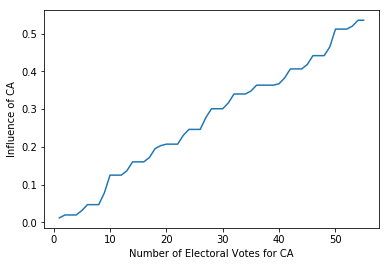

In [65]:
"""Order: CA,TX,FL,NY,IL,PA,OH,GA,MI,NC,NJ, (Shortened for comp purposes)"""
EC_votes = [55,38,29,29,20,20,18,16,16,15,14]
#U = some relevant exogenous var(e.g. every state's election is not rigged)
# V = the votes for each state, following EC_votes ordering and upholding scenario (Dem win by 1 vote)
# Assumes: True = Vote for Dem. ; False = Vote for Rep.
U = [True for i in range(11)]
V = [True,False,True,False,True,False,True,False,False,False,True,True,False]
R = [(False,True) for i in range(len(V))]
#Counts the votes and excludes last 2 elem of V which corresp to Dem_win, Rep_win
def dem_win(U,V):
    true_vote_idx = [i for i in range(len(V[0:-2])) if V[i] == True]
    num_votes = sum([EC_votes[i] for i in true_vote_idx])
    return num_votes > (int(sum(EC_votes)/2))
F = [None for i in range(len(U))] + [dem_win, not dem_win]
X = [True]
X_indices = [0]
num_outcome = 2
outcome_func = dem_win
CA_votes = [i for i in range(1,56)]
CA_inf = []
for i in CA_votes:
    EC_votes[0] = i
    EC_model = Causal_Model(U,V,R,F)
    CA_inf.append(EC_model.influence(X,X_indices,num_outcome,outcome_func))
CA_votes = np.asarray(CA_votes)
CA_inf = np.asarray(CA_inf)
plt.plot(CA_votes,CA_inf)
plt.xlabel('Number of Electoral Votes for CA')
plt.ylabel('Influence of CA')

Text(0, 0.5, 'Influence of CA')

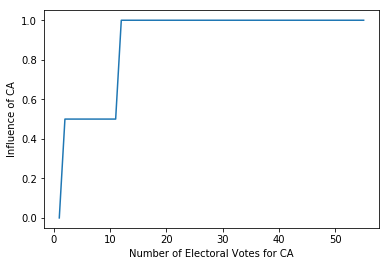

In [66]:
"""Order: CA,TX,FL,NY (Shortened for comp purposes)"""
EC_votes = [10,5,3,3]
#U = some relevant exogenous var(e.g. every state's election is not rigged)
# V = the votes for each state, following EC_votes ordering and upholding scenario (Dem win by 1 vote)
# Assumes: True = Vote for Dem. ; False = Vote for Rep.
U = [True for i in range(4)]
V = [True,False,True,False,True,False]
R = [(False,True) for i in range(len(V))]
#Counts the votes and excludes last 2 elem of V which corresp to Dem_win, Rep_win
def dem_win(U,V):
    true_vote_idx = [i for i in range(len(V[0:-2])) if V[i] == True]
    num_votes = sum([EC_votes[i] for i in true_vote_idx])
    return num_votes > (int(sum(EC_votes)/2))
F = [None for i in range(len(U))] + [dem_win, not dem_win]
X = [True]
X_indices = [0]
num_outcome = 2
outcome_func = dem_win
CA_votes = [i for i in range(1,56)]
CA_inf = []
for i in CA_votes:
    EC_votes[0] = i
    EC_model = Causal_Model(U,V,R,F)
    CA_inf.append(EC_model.influence(X,X_indices,num_outcome,outcome_func))
CA_votes = np.asarray(CA_votes)
CA_inf = np.asarray(CA_inf)
plt.plot(CA_votes,CA_inf)
plt.xlabel('Number of Electoral Votes for CA')
plt.ylabel('Influence of CA')

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
BEST OF 21 TOTAL VOTES


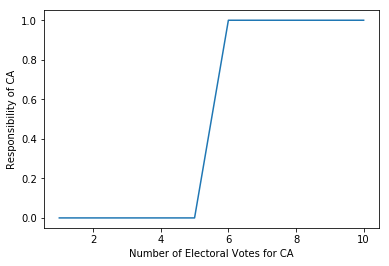

In [67]:
"""Order: CA,TX,FL,NY (Shortened for comp purposes)"""
EC_votes = [10,5,3,3]
#U = some relevant exogenous var(e.g. every state's election is not rigged)
# V = the votes for each state, following EC_votes ordering and upholding scenario (Dem win by 1 vote)
# Assumes: True = Vote for Dem. ; False = Vote for Rep.
U = [True for i in range(4)]
V = [True,False,True,False,True,False]
R = [(False,True) for i in range(len(V))]
#Counts the votes and excludes last 2 elem of V which corresp to Dem_win, Rep_win
CA_votes = [i for i in range(1,11)]
CA_resp = []
for i in CA_votes:
    EC_votes[0] = i
    EC_model = Causal_Model(U,V,R,F)
    CA_resp.append(EC_model.responsibility(X,X_indices,outcome_func(U,V),outcome_func,True))
CA_votes = np.asarray(CA_votes)
CA_resp = np.asarray(CA_resp)
plt.plot(CA_votes,CA_resp)
plt.xlabel('Number of Electoral Votes for CA')
plt.ylabel('Responsibility of CA')
print("BEST OF 21 TOTAL VOTES")

1
(False b/c of AC2)
2
(False b/c of AC2)
3
(False b/c of AC2)
4
(False b/c of AC2)
5
(False b/c of AC2)
6
7
8
9
10
BEST of 21


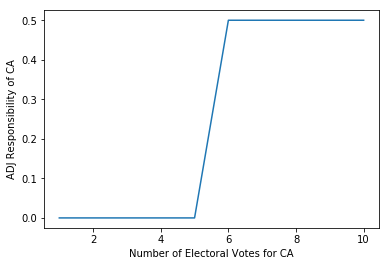

In [68]:
CA_votes = [i for i in range(1,11)]
CA_resp = []
for i in CA_votes:
    print(i)
    EC_votes[0] = i
    EC_model = Causal_Model(U,V,R,F)
    CA_resp.append(EC_model.adj_responsibility(X,X_indices,2,outcome_func(U,V),outcome_func,True))
CA_votes = np.asarray(CA_votes)
CA_resp = np.asarray(CA_resp)
plt.plot(CA_votes,CA_resp)
plt.xlabel('Number of Electoral Votes for CA')
plt.ylabel('ADJ Responsibility of CA')
print("BEST of 21")

In [69]:
CA_votes = [i for i in range(1,11)]
CA_resp = []
CA_zresp = []
for i in CA_votes:
    EC_votes[0] = i
    EC_model = Causal_Model(U,V,R,F)
    resp_defn = EC_model.adj_responsibility_2m(X,X_indices,2,outcome_func(U,V),outcome_func,True)
    CA_resp.append(resp_defn[0])
    CA_zresp.append(resp_defn[1])
CA_votes = np.asarray(CA_votes)
CA_resp = np.asarray(CA_resp)
plt.plot(CA_votes,CA_resp,color='blue',label='adj2')
plt.plot(CA_votes,CA_zresp,color='red',linestyle = 'dashed')
plt.xlabel('Number of Electoral Votes for CA')
plt.ylabel("Adjusted Responsibilities (R=Zultan, B =ADJ2)")
print("BEST of 21")

(False b/c of AC2)


TypeError: 'int' object is not subscriptable

In [ ]:
### PRoblem: Present in current situation (i.e. W= {}) vs present in many (any dilemma?)
###Sum over influence of X in diff world


###The resp of W_changed doesn't match intuition b/c in conj. scenario the W is trivial/empty so it sets responsibility = 0
###
### Try adj_2 negative (num_changed_var-adj_2), only over min_W
####Finding more examples
####Maybe that's a good thing? If we don't change major variables?
###Try (A or B) and C and D



## Intuitive Defn of Responsibility Test Suite
### Testing for the following intuitive "priniciples", from Causal Responsibility and Counterfactuals (Lagnado,Gerstenberg, Zultan 2014):
#### 1) In disj (or) scenario: 
##### a. As # ppl = TRUE increase, responsibility/person decreases
##### b. If one agent (A) succeeds, rest fail => A gets full resp (1), every1-else 0
#### 2) In conj(and) scenario:
##### a. If outcome successful, then everyone gets full credit/responsibility
##### b. If outcome is failure, then responsibility for agent who failed (individually) increases as number of successful individuals increases

## Test Suites: 
### 1. Disjunctive (A or B or C ....)
### 2. Conjunctive (A and B and C....)
### 3. Combination ( (A or B) and C and D)

# Test Suite 1: Disjunctive

### Here EVERY agent (i.e. team member) is TRUE

!!!
!!!
!!!


Text(0.5, 1.0, 'Disjunctive Scenario (everyone is True)')

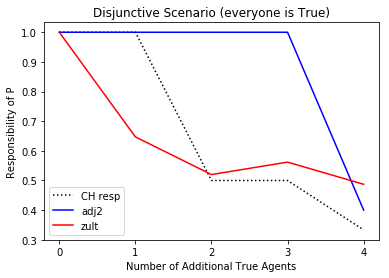

In [64]:
def disjunc(U,V):
    num_agents = len(V)-1
    lst_of_agent_outcomes = [1 if V[i] == True else 0 for i in range(0,num_agents)]
    return sum(lst_of_agent_outcomes) >= 1

og_r = []
adj_1 = []
adj_2 = []
adj_z = []
for i in range(5):
    U = [True for j in range(i+1)]
    V = [True for j in range(i+2)]
    R = [(False,True) for j in range(i+1)]
    F = [None for j in range(i+1)] + [disjunc]
    Disj_Model = Causal_Model(U,V,R,F)
    X = [True]
    X_index = [0]
    r = Disj_Model.responsibility(X,X_index,V[-1],disjunc,False)
    og_r.append(r)
    adj_1.append(Disj_Model.adj_responsibility(X,X_index,1,V[-1],disjunc,True))
    adj_zult = Disj_Model.adj_responsibility_2m(X,X_index,1,V[-1],disjunc,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])    
num_agents = np.asarray([i for i in range(5)])
og_r = np.asarray(og_r)
#adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.plot(num_agents,og_r, color = 'black',linestyle=':',label = 'CH resp')
#plt.plot(num_agents,adj_1, color = 'green',label='adj1')
plt.plot(num_agents,adj_2, color = 'blue',label='adj2')
plt.plot(num_agents,adj_z, color='red',label = 'zult')
plt.legend(loc='lower left')
plt.xlabel('Number of Additional True Agents')
plt.ylabel('Responsibility of P')
plt.xticks([0,1,2,3,4])
plt.title("Disjunctive Scenario (everyone is True)")

### Testing for a FAILed outcomed

Text(0.5, 1.0, 'Disjunctive (Everyone = False)')

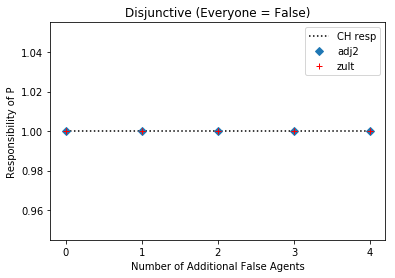

In [65]:
og_r = []
adj_1 = []
adj_2 = []
adj_z = []
for i in range(5):
    U = [True for j in range(i+1)]
    V = [False for j in range(i+2)]
    R = [(False,True) for j in range(i+1)]
    F = [None for j in range(i)] + [disjunc]
    Disj_Model = Causal_Model(U,V,R,F)
    X = [False]
    X_index = [0]
    r = Disj_Model.responsibility(X,X_index,V[-1],disjunc,False)
    og_r.append(r)
    adj_1.append(Disj_Model.adj_responsibility(X,X_index,1,V[-1],disjunc,True))
    adj_zult = Disj_Model.adj_responsibility_2m(X,X_index,1,V[-1],disjunc,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1]) 
num_agents = np.asarray([i for i in range(5)])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.plot(num_agents,og_r, color = 'black',linestyle=":",label = 'CH resp')
#plt.plot(num_agents,adj_1, color = 'green',label='adj1')
plt.plot(num_agents,adj_2, 'D',label='adj2')
plt.plot(num_agents,adj_z, 'r+',label = 'zult')
plt.legend(loc='upper right')
plt.xlabel('Number of Additional False Agents')
plt.ylabel('Responsibility of P')
plt.xticks([0,1,2,3,4])
plt.title("Disjunctive (Everyone = False)")

### Testing for scenario:  Only 1 agent True, everyone-else fails
#### Plotting responsibility of the TRUE agent

Text(0.5, 1.0, 'Disjunctive (P = True, Everyone-else = False)')

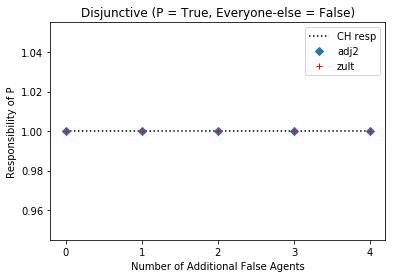

In [66]:
og_r = []
adj_1 = []
adj_2 = []
adj_z = []
U = [True]
V = [True,True]
R = [(False,True)]
F = [None,disjunc]
Disj_Model = Causal_Model(U,V,R,F)
X = [True]
X_index = [0]
r = Disj_Model.responsibility(X,X_index,V[-1],disjunc,False)
og_r.append(r)
adj_1.append(Disj_Model.adj_responsibility(X,X_index,1,V[-1],disjunc,True))
adj_zult = Disj_Model.adj_responsibility_2m(X,X_index,1,V[-1],disjunc,False)
adj_2.append(adj_zult[0])
adj_z.append(adj_zult[1])   
for i in range(4):
    U.append(True)
    V = V[:-1]+[False]+[V[-1]]
    R.append((False,True))
    F = F[:-1] + [None] + [F[-1]]
    Disj_Model = Causal_Model(U,V,R,F)
    X = [True]
    X_index = [0]
    r = Disj_Model.responsibility(X,X_index,V[-1],disjunc,False)
    og_r.append(r)
    adj_1.append(Disj_Model.adj_responsibility(X,X_index,1,V[-1],disjunc,True))
    adj_zult = Disj_Model.adj_responsibility_2m(X,X_index,1,V[-1],disjunc,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])    
num_agents = np.asarray([i for i in range(5)])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.plot(num_agents,og_r, color = 'black',linestyle=":",label = 'CH resp')
#plt.plot(num_agents,adj_1, color = 'green',label='adj1')
plt.plot(num_agents,adj_2, 'D',label='adj2')
plt.plot(num_agents,adj_z, 'r+',label = 'zult')
plt.legend(loc='upper right')
plt.xlabel('Number of Additional False Agents')
plt.ylabel('Responsibility of P')
plt.xticks([0,1,2,3,4])
plt.title("Disjunctive (P = True, Everyone-else = False)")

#### Plotting responsibility of a FALSE agent

(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)
(False b/c of AC1)
(False b/c of AC2)


Text(0.5, 1.0, 'Disjunctive (P = F, Q = T, Additional_Agent = F)')

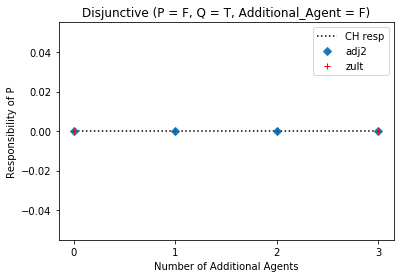

In [67]:
og_r = []
adj_1 = []
adj_2 = []
adj_z = []
U = [True,True]
V = [False,True]
R = [(False,True),(False,True)]
F = [None,None,disjunc]
Disj_Model = Causal_Model(U,V,R,F)
X = [False]
X_index = [0]
r = Disj_Model.responsibility(X,X_index,V[-1],disjunc,False)
og_r.append(r)
adj_1.append(Disj_Model.adj_responsibility(X,X_index,1,V[-1],disjunc,True))
adj_zult = Disj_Model.adj_responsibility_2m(X,X_index,1,V[-1],disjunc,False)
adj_2.append(adj_zult[0])
adj_z.append(adj_zult[1])  
for i in range(3):
    U.append(True)
    V = V[:-1]+[False]+[V[-1]]
    R.append((False,True))
    F = F[:-1] + [None] + [F[-1]]
    Disj_Model = Causal_Model(U,V,R,F)
    X = [False]
    X_index = [0]
    r = Disj_Model.responsibility(X,X_index,V[-1],disjunc,False)
    og_r.append(r)
    adj_1.append(Disj_Model.adj_responsibility(X,X_index,1,V[-1],disjunc,True))
    adj_zult = Disj_Model.adj_responsibility_2m(X,X_index,1,V[-1],disjunc,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])    
num_agents = np.asarray([i for i in range(4)])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.plot(num_agents,og_r, color = 'black',linestyle=":",label = 'CH resp')
#plt.plot(num_agents,adj_1, color = 'green',label='adj1')
plt.plot(num_agents,adj_2, 'D',label='adj2')
plt.plot(num_agents,adj_z, 'r+',label = 'zult')
plt.legend(loc='upper right')
plt.xlabel('Number of Additional Agents')
plt.ylabel('Responsibility of P')
plt.xticks([0,1,2,3])
plt.title("Disjunctive (P = F, Q = T, Additional_Agent = F)")

# Test Suite 2: Conjunctive

### Testing scenario where outcome  = TRUE
### Expecting responsibility = 1

Text(0.5, 1.0, 'Conjunctive (Outcome=True)')

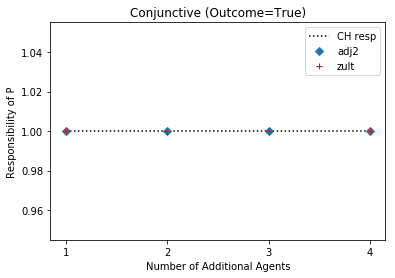

In [68]:
def conj(U,V):
    num_agents = len(V)-1
    lst_of_agent_outcomes = [1 if V[i] == True else 0 for i in range(0,num_agents)]
    return sum(lst_of_agent_outcomes) == num_agents

og_r = []
adj_1 = []
adj_2 = []
adj_z = []
for i in range(1,5):
    U = [True for j in range(i+1)]
    V = [True for j in range(i+1)]
    R = [(False,True) for j in range(i+1)]
    F = [None for j in range(i)] + [conj]
    Conj_Model = Causal_Model(U,V,R,F)
    X = [True]
    X_index = [0]
    r = Conj_Model.responsibility(X,X_index,V[-1],conj,False)
    og_r.append(r)
    adj_1.append(Conj_Model.adj_responsibility(X,X_index,1,V[-1],conj,True))
    adj_zult = Conj_Model.adj_responsibility_2m(X,X_index,1,V[-1],conj,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])    
num_agents = np.asarray([i for i in range(1,5)])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.plot(num_agents,og_r, color = 'black',linestyle=':',label = 'CH resp')
#plt.plot(num_agents,adj_1, color = 'green',label='adj1')
plt.plot(num_agents,adj_2, 'D',label='adj2')
plt.plot(num_agents,adj_z, 'r+',label = 'zult')
plt.legend(loc='upper right')
plt.xlabel('Number of Additional Agents')
plt.ylabel('Responsibility of P')
plt.xticks([1,2,3,4])
plt.title("Conjunctive (Outcome=True)")

### Testing scenario where outcome  = False 
#### Plot for agent who was TRUE

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)


Text(0.5, 1.0, 'Conjunctive (P=F,Q=T,Additional_Agent=F)')

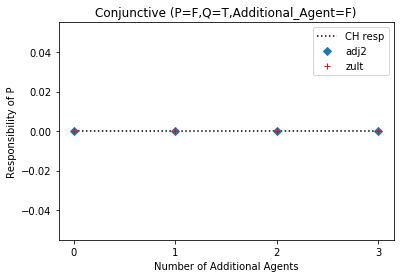

In [69]:
og_r = []
adj_1 = []
adj_2 = []
adj_z = []
U = [True,True]
V = [True,False]
R = [(False,True)]
F = [None,conj]
for i in range(4):
    U.append(True)
    V = V[:-1] + [False] + [V[-1]]
    R.append((False,True))
    F = F[:-1]+[None]+[F[-1]]
    Conj_Model = Causal_Model(U,V,R,F)
    X = [True]
    X_index = [0]
    r = Conj_Model.responsibility(X,X_index,V[-1],conj,False)
    og_r.append(r)
    adj_1.append(Conj_Model.adj_responsibility(X,X_index,1,V[-1],conj,True))
    adj_zult = Conj_Model.adj_responsibility_2m(X,X_index,1,V[-1],conj,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])    
num_agents = np.asarray([i for i in range(4)])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.plot(num_agents,og_r, color = 'black',linestyle=":",label = 'CH resp')
#plt.plot(num_agents,adj_1, color = 'green',label='adj1')
plt.plot(num_agents,adj_2, 'D',label='adj2')
plt.plot(num_agents,adj_z, 'r+',label = 'zult')
plt.legend(loc='upper right')
plt.xlabel('Number of Additional Agents')
plt.ylabel('Responsibility of P')
plt.xticks([0,1,2,3])
plt.title("Conjunctive (P=F,Q=T,Additional_Agent=F)")

### Testing scenario where outcome  = False 
#### Plot for agent who was False

!!!
!!!
!!!


Text(0.5, 1.0, 'Conjunctive (P=F,Additional_Agent=F)')

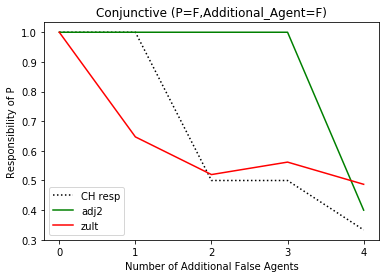

In [70]:
og_r = []
adj_1 = []
adj_2 = []
adj_z = []
U = [True,True]
V = [False,False]
R = [(False,True)]
F = [None,conj]
Conj_Model = Causal_Model(U,V,R,F)
X = [False]
X_index = [0]
og_r.append(Conj_Model.responsibility(X,X_index,V[-1],conj,False))
adj_1.append(Conj_Model.adj_responsibility(X,X_index,1,V[-1],conj,True))
adj_zult = Conj_Model.adj_responsibility_2m(X,X_index,1,V[-1],conj,False)
adj_2.append(adj_zult[0])
adj_z.append(adj_zult[1])    
for i in range(4):
    U.append(True)
    V = V[:-1] + [False] + [V[-1]]
    R.append((False,True))
    F = F[:-1]+[None]+[F[-1]]
    Conj_Model = Causal_Model(U,V,R,F)
    X = [False]
    X_index = [0]
    r = Conj_Model.responsibility(X,X_index,V[-1],conj,False)
    og_r.append(r)
    adj_1.append(Conj_Model.adj_responsibility(X,X_index,1,V[-1],conj,True))
    adj_zult = Conj_Model.adj_responsibility_2m(X,X_index,1,V[-1],conj,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])    
num_agents = np.asarray([i for i in range(5)])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.plot(num_agents,og_r, color = 'black',linestyle=':',label = 'CH resp')
#plt.plot(num_agents,adj_1, color = 'green',label='adj1')
plt.plot(num_agents,adj_2, color = 'green',label='adj2')
plt.plot(num_agents,adj_z, color='red',label = 'zult')
plt.legend(loc='lower left')
plt.xlabel('Number of Additional False Agents')
plt.ylabel('Responsibility of P')
plt.xticks([0,1,2,3,4])
plt.title("Conjunctive (P=F,Additional_Agent=F)")

# Test Suite 3: (A or B) and C and D

### Testing scenario where everyone  = TRUE
### TBD THE INTUITION!!
#### My Intuition Guess: C,D = 1 | A,B = 1/2 (b/c they are or)

!!!
!!!


Text(0.5, 1.0, '(A or B) and C and D | Scenario: Everyone is True')

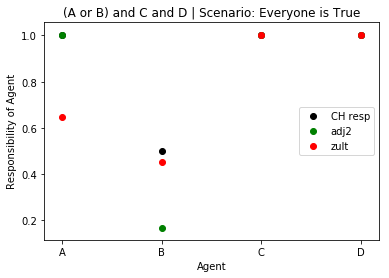

In [71]:
def scenario(U,V):
    return (V[0] or V[1]) and V[2] and V[3]

U = [True for i in range(4)]
V = [True for i in range(5)]
R = [(False,True) for i in range(5)]
F = [None for i in range(4)] + [scenario]
Scenario_Model = Causal_Model(U,V,R,F)
og_r=[]
adj_1=[]
adj_2 = []
adj_z = []
for i in range(4):
    X = [V[i]]
    X_index = [i]
    r = Scenario_Model.responsibility(X,X_index,V[-1],scenario,False)
    og_r.append(r)
    adj_1.append(Scenario_Model.adj_responsibility(X,X_index,1,V[-1],scenario,True))
    adj_zult = Scenario_Model.adj_responsibility_2m(X,X_index,1,V[-1],scenario,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])
num_agents = np.asarray(['A','B','C','D'])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.scatter(num_agents,og_r, color = 'black',label = 'CH resp')
#plt.scatter(num_agents,adj_1, color = 'green',label='adj1')
plt.scatter(num_agents,adj_2, color = 'green',label='adj2')
plt.scatter(num_agents,adj_z, color = 'red',label = 'zult')
plt.legend(loc='right')
plt.xlabel('Agent')
plt.ylabel('Responsibility of Agent')
plt.title("(A or B) and C and D | Scenario: Everyone is True")

### Testing scenario where A is False, everyone-else is TRUE
### TBD THE INTUITION!!
#### My intuition : A = 0, B = 1, C=1, D = 1

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)


Text(0.5, 1.0, '(A or B) and C and D |Scenario: A = False, EveryoneElse = T')

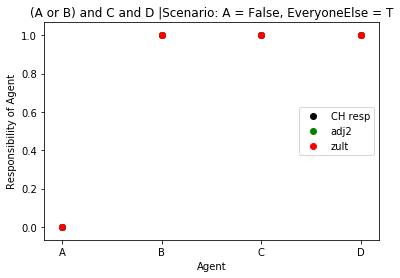

In [72]:
def scenario(U,V):
    return (V[0] or V[1]) and V[2] and V[3]

U = [True for i in range(4)]
V = [False] + [True for i in range(4)]
R = [(False,True) for i in range(5)]
F = [None for i in range(4)] + [scenario]
Scenario_Model = Causal_Model(U,V,R,F)
og_r=[]
adj_1=[]
adj_2 = []
adj_z = []
for i in range(4):
    X = [V[i]]
    X_index = [i]
    r = Scenario_Model.responsibility(X,X_index,V[-1],scenario,False)
    og_r.append(r)
    adj_1.append(Scenario_Model.adj_responsibility(X,X_index,1,V[-1],scenario,True))
    adj_zult = Scenario_Model.adj_responsibility_2m(X,X_index,1,V[-1],scenario,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])
num_agents = np.asarray(['A','B','C','D'])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.scatter(num_agents,og_r, color = 'black',label = 'CH resp')
#plt.scatter(num_agents,adj_1, color = 'green',label='adj1')
plt.scatter(num_agents,adj_2, color = 'green',label='adj2')
plt.scatter(num_agents,adj_z, color = 'red',label = 'zult')
plt.legend(loc='right')
plt.xlabel('Agent')
plt.ylabel('Responsibility of Agent')
plt.title("(A or B) and C and D |Scenario: A = False, EveryoneElse = T")

### Testing scenario where B is False, everyone-else is TRUE
### TBD THE INTUITION!!
#### My intuition: A = 1, B = 0, C=D=1

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)


Text(0.5, 1.0, '(A or B) and C and D | Scenario: B = False, EveryoneElse = T')

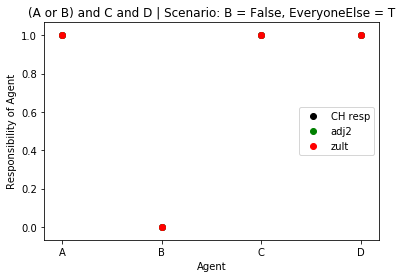

In [73]:
def scenario(U,V):
    return (V[0] or V[1]) and V[2] and V[3]

U = [True for i in range(4)]
V = [True] + [False] + [True for i in range(3)]
R = [(False,True) for i in range(5)]
F = [None for i in range(4)] + [scenario]
Scenario_Model = Causal_Model(U,V,R,F)
og_r=[]
adj_1=[]
adj_2 = []
adj_z = []
for i in range(4):
    X = [V[i]]
    X_index = [i]
    r = Scenario_Model.responsibility(X,X_index,V[-1],scenario,False)
    og_r.append(r)
    adj_1.append(Scenario_Model.adj_responsibility(X,X_index,1,V[-1],scenario,True))
    adj_zult = Scenario_Model.adj_responsibility_2m(X,X_index,1,V[-1],scenario,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])
num_agents = np.asarray(['A','B','C','D'])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.scatter(num_agents,og_r, color = 'black',label = 'CH resp')
#plt.scatter(num_agents,adj_1, color = 'green',label='adj1')
plt.scatter(num_agents,adj_2, color = 'green',label='adj2')
plt.scatter(num_agents,adj_z, color = 'red',label = 'zult')
plt.legend(loc='right')
plt.xlabel('Agent')
plt.ylabel('Responsibility of Agent')
plt.title("(A or B) and C and D | Scenario: B = False, EveryoneElse = T")

### Testing scenario where A = B = False, everyone-else is TRUE
### TBD THE INTUITION!!
#### My intution: Since outcome = False, A=B=1 and C=D=1/2?

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)


Text(0.5, 1.0, '(A or B) and C and D ; Scenario: A=B=F, C=D= T')

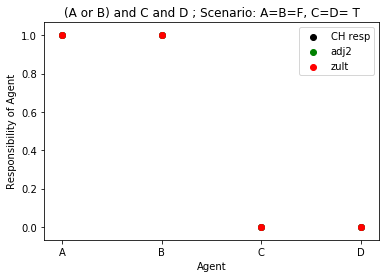

In [74]:
def scenario(U,V):
    return (V[0] or V[1]) and V[2] and V[3]

U = [True for i in range(4)]
V = [False] + [False] + [True for i in range(2)] + [False]
R = [(False,True) for i in range(5)]
F = [None for i in range(4)] + [scenario]
Scenario_Model = Causal_Model(U,V,R,F)
og_r=[]
adj_1=[]
adj_2 = []
adj_z = []
for i in range(4):
    X = [V[i]]
    X_index = [i]
    r = Scenario_Model.responsibility(X,X_index,V[-1],scenario,False)
    og_r.append(r)
    adj_1.append(Scenario_Model.adj_responsibility(X,X_index,1,V[-1],scenario,True))
    adj_zult = Scenario_Model.adj_responsibility_2m(X,X_index,1,V[-1],scenario,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])
num_agents = np.asarray(['A','B','C','D'])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.scatter(num_agents,og_r, color = 'black',label = 'CH resp')
#plt.scatter(num_agents,adj_1, color = 'green',label='adj1')
plt.scatter(num_agents,adj_2, color = 'green',label='adj2')
plt.scatter(num_agents,adj_z, color = 'red',label = 'zult')
plt.legend(loc='upper right')
plt.xlabel('Agent')
plt.ylabel('Responsibility of Agent')
plt.title("(A or B) and C and D ; Scenario: A=B=F, C=D= T")

### Testing scenario where C = False, everyone-else is TRUE
#### My intution: Similar to above (C = 1, A=B=D = 0)

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)


Text(0.5, 1.0, '(A or B) and C and D | Scenario: A=B=D=T, C=F')

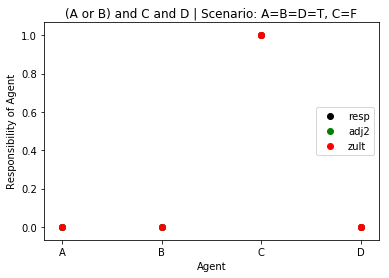

In [75]:
def scenario(U,V):
    return (V[0] or V[1]) and V[2] and V[3]

U = [True for i in range(4)]
V = [True for i in range(5)]
V[2] = False
V[4] = False
R = [(False,True) for i in range(5)]
F = [None for i in range(4)] + [scenario]
Scenario_Model = Causal_Model(U,V,R,F)
og_r=[]
adj_1=[]
adj_2 = []
adj_z = []
for i in range(4):
    X = [V[i]]
    X_index = [i]
    r = Scenario_Model.responsibility(X,X_index,V[-1],scenario,False)
    og_r.append(r)
    adj_1.append(Scenario_Model.adj_responsibility(X,X_index,1,V[-1],scenario,True))
    adj_zult = Scenario_Model.adj_responsibility_2m(X,X_index,1,V[-1],scenario,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])
num_agents = np.asarray(['A','B','C','D'])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.scatter(num_agents,og_r, color = 'black',label = 'resp')
#plt.scatter(num_agents,adj_1, color = 'green',label='adj1')
plt.scatter(num_agents,adj_2, color = 'green',label='adj2')
plt.scatter(num_agents,adj_z, color = 'red',label = 'zult')
plt.legend(loc='right')
plt.xlabel('Agent')
plt.ylabel('Responsibility of Agent')
plt.title("(A or B) and C and D | Scenario: A=B=D=T, C=F")

### Testing scenario where A=C = False, everyone-else is TRUE
### TBD THE INTUITION!!
#### My intuition: A= 1/2, C = 1 and B=D=0

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)


Text(0.5, 1.0, '(A or B) and C and D ; Scenario: A=C=F, B=D= T')

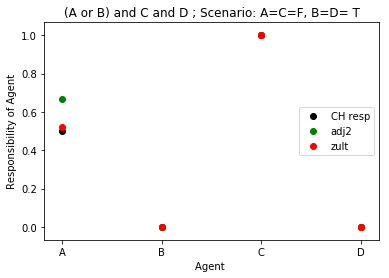

In [76]:
def scenario(U,V):
    return (V[0] or V[1]) and V[2] and V[3]

U = [True for i in range(4)]
V = [True for i in range(5)]
V[0] = False
V[2] = False
V[4] = False
R = [(False,True) for i in range(5)]
F = [None for i in range(4)] + [scenario]
Scenario_Model = Causal_Model(U,V,R,F)
og_r=[]
adj_1=[]
adj_2 = []
adj_z = []
for i in range(4):
    X = [V[i]]
    X_index = [i]
    r = Scenario_Model.responsibility(X,X_index,V[-1],scenario,False)
    og_r.append(r)
    adj_1.append(Scenario_Model.adj_responsibility(X,X_index,1,V[-1],scenario,True))
    adj_zult = Scenario_Model.adj_responsibility_2m(X,X_index,1,V[-1],scenario,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])
num_agents = np.asarray(['A','B','C','D'])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.scatter(num_agents,og_r, color = 'black',label = 'CH resp')
#plt.scatter(num_agents,adj_1, color = 'green',label='adj1')
plt.scatter(num_agents,adj_2, color = 'green',label='adj2')
plt.scatter(num_agents,adj_z, color = 'red',label = 'zult')
plt.legend(loc='right')
plt.xlabel('Agent ')
plt.ylabel('Responsibility of Agent')
plt.title("(A or B) and C and D ; Scenario: A=C=F, B=D= T")

!!!
!!!
!!!
!!!


Text(0.5, 1.0, '(A or B) and C and D ; Scenario: All False')

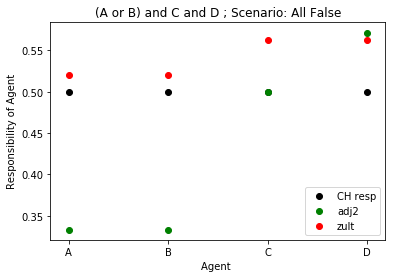

In [77]:
def scenario(U,V):
    return (V[0] or V[1]) and V[2] and V[3]

U = [True for i in range(4)]
V = [False for i in range(5)]
R = [(False,True) for i in range(5)]
F = [None for i in range(4)] + [scenario]
Scenario_Model = Causal_Model(U,V,R,F)
og_r=[]
adj_1=[]
adj_2 = []
adj_z = []
for i in range(4):
    X = [V[i]]
    X_index = [i]
    r = Scenario_Model.responsibility(X,X_index,V[-1],scenario,False)
    og_r.append(r)
    adj_1.append(Scenario_Model.adj_responsibility(X,X_index,1,V[-1],scenario,True))
    adj_zult = Scenario_Model.adj_responsibility_2m(X,X_index,1,V[-1],scenario,False)
    adj_2.append(adj_zult[0])
    adj_z.append(adj_zult[1])
num_agents = np.asarray(['A','B','C','D'])
og_r = np.asarray(og_r)
adj_1 = np.asarray(adj_1)
adj_2 = np.asarray(adj_2)
adj_z = np.asarray(adj_z)
plt.scatter(num_agents,og_r, color = 'black',label = 'CH resp')
#plt.scatter(num_agents,adj_1, color = 'green',label='adj1')
plt.scatter(num_agents,adj_2, color = 'green',label='adj2')
plt.scatter(num_agents,adj_z, color = 'red',label = 'zult')
plt.legend(loc='best')
plt.xlabel('Agent ')
plt.ylabel('Responsibility of Agent')
plt.title("(A or B) and C and D ; Scenario: All False")